In [ ]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop

In [ ]:
#''' Train and path '''
train_path = pathlib.Path("/content/drive/MyDrive/FYP/Dataset FYP/skin cancer ISIC/Train")
test_path = pathlib.Path("/content/drive/MyDrive/FYP/Dataset FYP/skin cancer ISIC/Test")
val_path = pathlib.Path("/content/drive/MyDrive/FYP/Dataset FYP/skin cancer ISIC/Val")

In [ ]:
print(len(list(train_path.glob('*/*.jpg'))))
print(len(list(val_path.glob('*/*.jpg'))))
print(len(list(test_path.glob('*/*.jpg'))))

1571
314
51


In [ ]:
batch_size = 128
image_w = 224
image_h = 224

In [ ]:
#''' Data augmentation '''
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed = 123,
    image_size = (image_h, image_w),
    batch_size = batch_size)

Found 1571 files belonging to 3 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed = 123,
    image_size = (image_h, image_w),
    batch_size = batch_size)

Found 314 files belonging to 3 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed = 123,
    image_size = (image_h, image_w),
    batch_size = batch_size)

Found 51 files belonging to 3 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

In [ ]:
from skimage import io

In [ ]:
#Load training data
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=2.0,
                    height_shift_range=2.0,
                    fill_mode = 'reflect')

#x = io.imread("/content/Classification cancerous mole/Data/Train/Melanoma/ISIC_0000002.jpg")
#x = x.reshape((1,) + x.shape)

#i=0
#for batch in train_datagen.flow(x, batch_size = 128,
#                                save_to_dir = "/content/Classification cancerous mole/Data/Augmented",
#                                save_prefix = "aug",
#                                save_format ="jpg"):
#  i+=1
 # if i > 20:
  #  break


#Load validation data
val_datagen = ImageDataGenerator(rescale=1.0/255)

#Load testing data
test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(
        train_path,  # Training Directory
        target_size=(image_h, image_w),
        batch_size = batch_size,
        # Multiclass problem, so i'm using "categorical" class mode
        class_mode='categorical')
 
val_gen = val_datagen.flow_from_directory(
        val_path, # Validation Directory
        target_size=(image_h, image_w),
        batch_size = batch_size, # Multiclass problem, so i'm using "categorical" class mode
        class_mode='categorical')

test_gen = test_datagen.flow_from_directory(test_path,
                                                 shuffle=True,
                                                 batch_size=batch_size,
                                                 target_size = (image_w, image_h),
                                                 class_mode='categorical')

Found 1571 images belonging to 3 classes.
Found 314 images belonging to 3 classes.
Found 51 images belonging to 3 classes.


In [ ]:
labels = {value: key for key, value in train_gen.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : melanoma
1 : nevus
2 : seborrheic keratosis


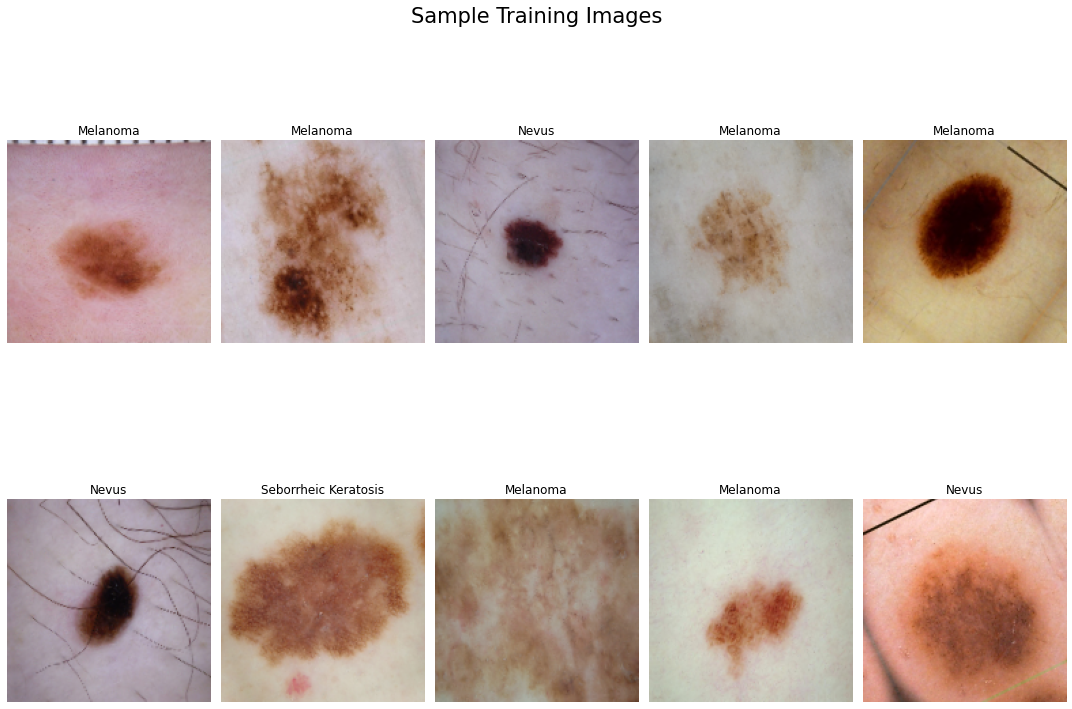

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_gen[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_gen[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [ ]:
model = tf.keras.models.Sequential([
    #First Convolution Layer                                
    tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Second Convolution Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Third Convolution layer
    tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Fourth Convolution layer
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),


    #First Hidden layers
    tf.keras.layers.Dense(32, activation="relu"),
    #Second Hidden Layers
    tf.keras.layers.Dense(16, activation="relu"),
    
    #Output Layer
    tf.keras.layers.Dense(3, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 16)       0

In [ ]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)

Epoch 1/20
13/13 [==============================] - 407s 31s/step - loss: 1.0981 - accuracy: 0.3482 - val_loss: 1.0925 - val_accuracy: 0.3790
Epoch 2/20
13/13 [==============================] - 121s 9s/step - loss: 1.0830 - accuracy: 0.3953 - val_loss: 1.0683 - val_accuracy: 0.4490
Epoch 3/20
13/13 [==============================] - 120s 9s/step - loss: 1.0495 - accuracy: 0.4672 - val_loss: 1.0296 - val_accuracy: 0.5191
Epoch 4/20
13/13 [==============================] - 122s 10s/step - loss: 1.0279 - accuracy: 0.4710 - val_loss: 0.9959 - val_accuracy: 0.5414
Epoch 5/20
13/13 [==============================] - 122s 9s/step - loss: 0.9859 - accuracy: 0.5016 - val_loss: 0.9742 - val_accuracy: 0.5573
Epoch 6/20
13/13 [==============================] - 124s 9s/step - loss: 0.9742 - accuracy: 0.5194 - val_loss: 0.9479 - val_accuracy: 0.5541
Epoch 7/20
13/13 [==============================] - 123s 9s/step - loss: 0.9432 - accuracy: 0.5500 - val_loss: 0.9220 - val_accuracy: 0.5669
Epoch 8/20


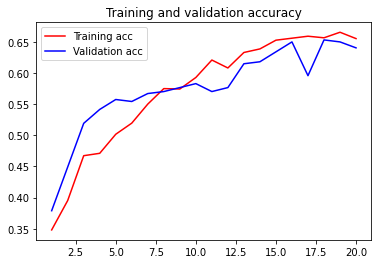

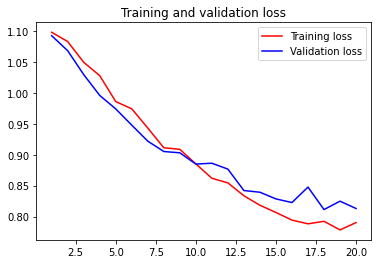

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test_gen)

1/1 [==============================] - 2s 2s/step


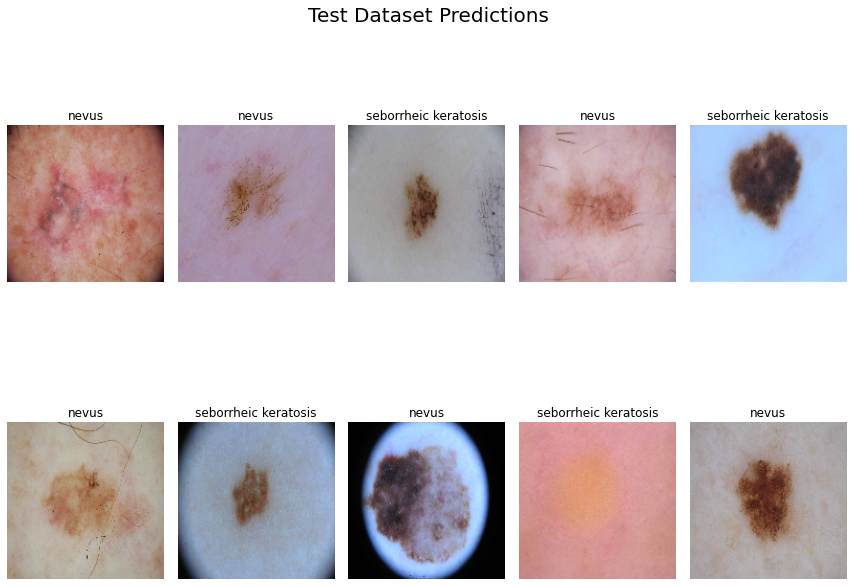

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_gen[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, batch_size=batch_size)

1/1 [==============================] - 2s 2s/step - loss: 0.9700 - accuracy: 0.6275


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.9699956774711609
Test Accuracy: 0.6274510025978088


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

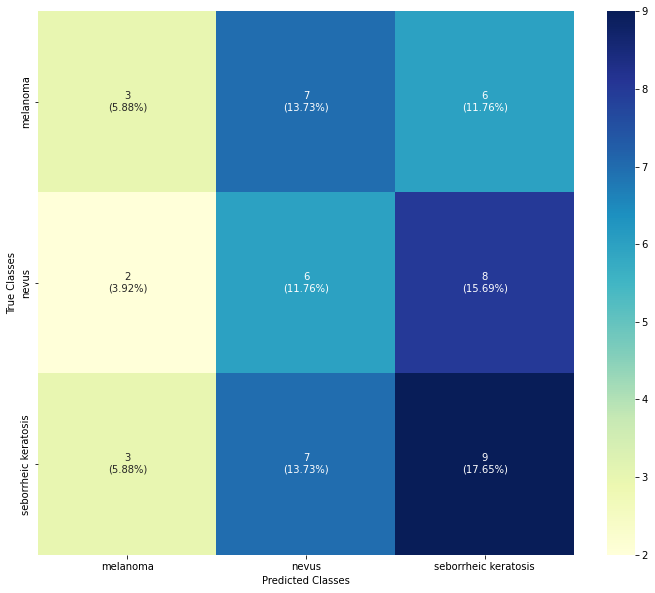

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(3, 3)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                      precision    recall  f1-score   support

            melanoma       0.38      0.19      0.25        16
               nevus       0.30      0.38      0.33        16
seborrheic keratosis       0.39      0.47      0.43        19

            accuracy                           0.35        51
           macro avg       0.36      0.35      0.34        51
        weighted avg       0.36      0.35      0.34        51



In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier1.h5'))

In [ ]:
class_names = train_ds.class_names
print(class_names)
numberOfClasses =len(class_names)

['melanoma', 'nevus', 'seborrheic keratosis']


In [ ]:
import random

classindex=random.randint(0,2)
imageindex=random.randint(0,3)

test_image_path=list(test_path.glob(class_names[classindex]+'/*.jpg'))[imageindex]
print(test_image_path)
print("Selecting test image of class ", class_names[classindex])

#Data transformation similar to train data
img = tf.keras.utils.load_img(test_image_path, target_size=(image_w, image_h))
img_array = tf.keras.utils.img_to_array(img)
print(img_array.shape)

#Data rescalling similar to train data
#img_array = img_array/255 # Rescaling
img_array = tf.expand_dims(img_array, 0) # Create a batch
print(img_array.shape)

/content/drive/MyDrive/FYP/Dataset FYP/skin cancer ISIC/Test/nevus/ISIC_0000007.jpg
Selecting test image of class  nevus
(224, 224, 3)
(1, 224, 224, 3)


In [ ]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
score

1/1 [==============================] - 0s 32ms/step


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.21194157, 0.5761169 , 0.21194157], dtype=float32)>

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to nevus with a 57.61 percent confidence.
